# LIST NR 2: Gradient methods. Automatic differentiation





In [37]:
import numpy as np
import torch
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from scipy.stats import uniform
import matplotlib.pyplot as plt

# Q2.1 (**10 pts**)
* Sample `x_test`, a vector of size 50 of i.i.d $\mathcal{U}(0,1)$ random variables and similarly compute corresponding

$\qquad$ `y_test = b_true + a_true * x_test + .1 * np.random.randn(nr_points, 1)`

In [2]:
nr_points = 200
np.random.seed(42)

x_train = np.random.rand(nr_points, 1)

a_true = 2.0
b_true = 1.0

y_train = b_true + a_true * x_train + .1 * np.random.randn(nr_points, 1)

x_test = np.random.rand(50, 1)
y_test = b_true + a_true * x_test + .1 * np.random.randn(50, 1)

* Take the model (aka `a` and `b`) trained on `(x_train,y_train)` and compute final loss on test set, i.e.,
$$\textrm{loss}_{\rm final} = {1\over n}\sum_{i=1}^{50} (a\cdot x\_{test} + b - y_{test})^2$$

In [5]:
LinReg = LinearRegression()
LinReg.fit(x_train, y_train)
a_est = LinReg.coef_.item()
b_est = LinReg.intercept_.item()

loss_final = np.mean((a_est * x_test + b_est - y_test) ** 2) # or mean_square_error

print(f"Value of loss_final is {loss_final}.")

Value of loss_final is 0.01199110714351241.


* Using SGD or Adam find new $a$ and $b$ minimizing function
$$g(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 + \lambda(a^2+b^2)$$
with $\lambda=0.1$

In [6]:
class TorchLinearRegression1D(RegressorMixin, BaseEstimator):

    def __init__(self, lr=0.06, lmb=0, n_epochs=500, optimizer_name="Adam", device=None):
        """
        Initialize the model with hyperparameters.

        Parameters:
            lr (float): Learning rate.
            lmb (float): Penalty value; if lmb = 0, then the standard linear regression is produced
            n_epochs (int): Number of training epochs.
            optimizer_name (str): Optimizer to use ("SGD" or "Adam").
            device (torch.device): Device to run computations on. Defaults to CPU.
        """
        self.lr = lr
        self.lmb = lmb
        self.n_epochs = n_epochs
        self.optimizer_name = optimizer_name
        self.device = device if device is not None else torch.device("cpu")
        self.a = None
        self.b = None
        self.loss_history = []
        self.a_history = []
        self.b_history = []

    def fit(self, x_train, y_train, verbose=False):

        x_train_tensor = torch.tensor(np.ravel(x_train), dtype=torch.float32, device=self.device).view(-1, 1)
        y_train_tensor = torch.tensor(np.ravel(y_train), dtype=torch.float32, device=self.device).view(-1, 1)

        # Initialize parameters a and b randomly, with gradient tracking.
        self.a = torch.randn(1, requires_grad=True, dtype=torch.float32, device=self.device)
        self.b = torch.randn(1, requires_grad=True, dtype=torch.float32, device=self.device)

        if self.optimizer_name.lower() == "sgd":
            optimizer = torch.optim.SGD([self.a, self.b], lr=self.lr)
        elif self.optimizer_name.lower() == "adam":
            optimizer = torch.optim.Adam([self.a, self.b], lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer. Choose 'SGD' or 'Adam'.")

        # Reset histories
        self.loss_history = []
        self.a_history = []
        self.b_history = []

        # Main training loop
        for epoch in range(self.n_epochs):

            yhat = self.a * x_train_tensor + self.b
            error = y_train_tensor - yhat
            loss = torch.mean(error ** 2) + self.lmb * (self.a ** 2 + self.b ** 2)

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            # Record training history every 10 epochs.
            if epoch % 10 == 0:
                self.loss_history.append(loss.item())
                self.a_history.append(self.a.item())
                self.b_history.append(self.b.item())
                if verbose:
                    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

        return self

    def predict(self, x):

        x_tensor = torch.tensor(np.ravel(x), dtype=torch.float32, device=self.device).view(-1, 1)
        y_prediction = self.a * x_tensor + self.b
        return y_prediction.detach().cpu().numpy().flatten()

In [7]:
model_LT = TorchLinearRegression1D(lmb=0.1, optimizer_name="sgd")
model_LT.fit(x_train, y_train, verbose=True)

print(f"The most optimal params a and b for g(a, b) loss function"
      f" are: a = {float(model_LT.a)}, b = {float(model_LT.b)}.")

Epoch 0: loss = 5.0025
Epoch 10: loss = 0.5972
Epoch 20: loss = 0.4426
Epoch 30: loss = 0.4204
Epoch 40: loss = 0.4081
Epoch 50: loss = 0.3999
Epoch 60: loss = 0.3945
Epoch 70: loss = 0.3909
Epoch 80: loss = 0.3885
Epoch 90: loss = 0.3869
Epoch 100: loss = 0.3859
Epoch 110: loss = 0.3852
Epoch 120: loss = 0.3847
Epoch 130: loss = 0.3844
Epoch 140: loss = 0.3842
Epoch 150: loss = 0.3841
Epoch 160: loss = 0.3840
Epoch 170: loss = 0.3839
Epoch 180: loss = 0.3839
Epoch 190: loss = 0.3839
Epoch 200: loss = 0.3838
Epoch 210: loss = 0.3838
Epoch 220: loss = 0.3838
Epoch 230: loss = 0.3838
Epoch 240: loss = 0.3838
Epoch 250: loss = 0.3838
Epoch 260: loss = 0.3838
Epoch 270: loss = 0.3838
Epoch 280: loss = 0.3838
Epoch 290: loss = 0.3838
Epoch 300: loss = 0.3838
Epoch 310: loss = 0.3838
Epoch 320: loss = 0.3838
Epoch 330: loss = 0.3838
Epoch 340: loss = 0.3838
Epoch 350: loss = 0.3838
Epoch 360: loss = 0.3838
Epoch 370: loss = 0.3838
Epoch 380: loss = 0.3838
Epoch 390: loss = 0.3838
Epoch 400: 

* Optimize    for `lambda>0` using `GridSearch` or `RandomizedSearch`. For fixed $\lambda$ find $\textrm{argmin}_{a,b} g(a,b)$ on the training set, and compute the $\textrm{loss}_{\rm final}$ on test set. Choose $\lambda$ that yields lowest $\textrm{loss}_{\rm final}$. Compare with $\lambda=0$ (i.e., original model).

In [9]:
lambda_grid = {'lmb': [0.0001, 0.001, 0.01, 0.1, 0.2]}

model = TorchLinearRegression1D(lr=0.1, n_epochs=1000)

grid_search = GridSearchCV(model, lambda_grid, cv=5, scoring='neg_mean_squared_error')
y_hat = grid_search.fit(x_train, y_train).predict(x_test)

loss_final_cv = mean_squared_error(y_test, y_hat)

model_2 = TorchLinearRegression1D(lr=0.1, lmb=grid_search.best_params_['lmb'], n_epochs=1000, optimizer_name="sgd")
model_2.fit(x_train, y_train)


print(f"The best lambda: {grid_search.best_params_['lmb']}, the loss_final: {loss_final_cv}")
print(f"Then the best parameters a and b are: a = {model_2.a.item()}, b = {model_2.b.item()}")

The best lambda: 0.0001, the loss_final: 0.012030831831220177
Then the best parameters a and b are: a = 1.9904531240463257, b = 1.0112613439559937


# Q2.2 (**10 pts**)
On previous list we considered Ridge Regression for 1d data (exact solution was provided). Now consider Ridge Regresion for multidimensional data:
We are given data points
$$(\textbf{x}_1,y_1),\ldots,(\textbf{x}_n,y_n)$$
where each $x_i \in \mathbb{R}^d$, and our goal is to estimate parameters $\beta_0, \ldots, \beta_d$  such that the model
$$
y = \beta_0 + \beta_1 x_1+\ldots +\beta_d x_d
$$
"best" fits the data. By "best" we mean that the parameters minimize the loss function
$$
g(\beta_0,\beta_1,\ldots,\beta_d, \lambda)=\sum_{i=1}^n \Bigl(y_i-(\beta_0+\mathbf{x}_i^T \boldsymbol{\beta})\Bigr)^2 +\lambda\sum_{i=0}^d \beta_i^2,
$$
where $\boldsymbol{\beta} = (\beta_1, \beta_2, \ldots, \beta_d)^T$ and $\mathbf{x}_i=(x_{i1},\ldots,x_{id})^T$  and $\lambda\geq 0$ is a hyperparamter.
* a) Implement multidimensional Ridge Regression `myRidgeRegression_multiD()` using gradient method (note: just form of loss function is needed, make options `sgd` and `adam` available). Preferred: implementation using a class.

In [11]:
class myRidgeRegression_multiD(RegressorMixin, BaseEstimator):

    def __init__(self, lr=0.06, lmb=0, n_epochs=500, optimizer_name="Adam", device=None):

        self.lr = lr
        self.lmb = lmb
        self.n_epochs = n_epochs
        self.optimizer_name = optimizer_name
        self.device = device if device is not None else torch.device("cpu")
        self.params = None
        self.loss_history = []
        self.params_history = []

    def fit(self, x_train, y_train, verbose=False):

        x_train_tensor = torch.tensor(np.c_[np.ones((x_train.shape[0], 1)), x_train], dtype=torch.float32,
                                      device=self.device).view(x_train.shape[0], x_train.shape[1] + 1)

        y_train_tensor = torch.tensor(np.ravel(y_train), dtype=torch.float32, device=self.device).view(-1, 1)

        self.params = torch.nn.Parameter(torch.randn(x_train_tensor.shape[1], 1, dtype=torch.float32, device=self.device))

        if self.optimizer_name.lower() == "sgd":
            optimizer = torch.optim.SGD([self.params], lr=self.lr)
        elif self.optimizer_name.lower() == "adam":
            optimizer = torch.optim.Adam([self.params], lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer. Choose 'SGD' or 'Adam'.")

        # Reset histories
        self.loss_history = []
        self.params_history = []

        # Main training loop
        for epoch in range(self.n_epochs):
            yhat = torch.matmul(x_train_tensor, self.params)
            error = y_train_tensor - yhat
            loss = torch.mean(torch.pow(error, 2)) + self.lmb * torch.sum(torch.pow(self.params, 2))

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            if epoch % 10 == 0:
                self.loss_history.append(loss.item())
                self.params_history.append([self.params[i] for i in range(len(self.params))])
                if verbose:
                    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

        return self

    def predict(self, x):
        x_tensor = torch.tensor(np.c_[np.ones((x.shape[0], 1)), x], dtype=torch.float32,
                                device=self.device).view(x.shape[0], x.shape[1] + 1)
        y_prediction = x_tensor @ self.params
        return y_prediction.detach().cpu().numpy().flatten()

In [28]:
model_ridge_reg = myRidgeRegression_multiD(lr=0.01, lmb=0.0001, n_epochs=1000)
model_ridge_reg.fit(x_train, y_train)
print(f"myRidgeRegression_multiD model's parameters: b0 = {model_ridge_reg.params[0].item()}, b1 = {model_ridge_reg.params[1].item()}")

# print(model_ridge_reg.params)

model_torch = TorchLinearRegression1D(lr=0.01, lmb=0.0001, n_epochs=1000)
model_torch.fit(x_train, y_train)
print(f"TorchLinearRegression1D model's parameters: b0 = {model_torch.b.item()}, b1 = {model_torch.a.item()}")

myRidgeRegression_multiD model's parameters: b0 = 1.1168948411941528, b1 = 1.7935035228729248
TorchLinearRegression1D model's parameters: b0 = 1.0186325311660767, b1 = 1.9764670133590698


* b) Re-consider California House Pricing from previous list. Choose several values of $\lambda$ and compare results with `myLinearRegression_multiD()`

In [20]:
class myLinearRegression_multiD:

    def __init__(self):
        self.betas = None

    def fit(self, X, y):
        matrix_plan = np.c_[np.ones((X.shape[0], 1)), X]
        self.betas = np.linalg.inv(matrix_plan.T @ matrix_plan) @ matrix_plan.T @ y
        return self

    def predict(self, X):
        matrix_plan = np.c_[np.ones((X.shape[0], 1)), X]
        return np.ravel(matrix_plan @ self.betas)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [23]:
data = fetch_california_housing()
X = data.data
Y = data.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [25]:
lambda_grid = {'lmb': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 2]}

model = myRidgeRegression_multiD(lr=0.01, n_epochs=1000)
grid_search = GridSearchCV(model, lambda_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)
y_hat = grid_search.best_estimator_.predict(X_test)

print(grid_search.cv_results_.get('mean_test_score'))

print("GridSearchCV best lambda:", grid_search.best_params_['lmb'])
print("GridSearchCV best CV MSE:", -grid_search.best_score_)
print("GridSearchCV best CV MSE (test set):", mean_squared_error(Y_test, y_hat))

model_linear_reg = myLinearRegression_multiD()
Y_prediction = model_linear_reg.fit(X_train, Y_train).predict(X_test)

print(f"MSE of linear model (test set): {mean_squared_error(Y_test, Y_prediction)}")

[-1863.76497464 -4573.09229025  -131.00720877  -221.627834
  -179.55472273 -1633.46239376  -336.48990995]
GridSearchCV best lambda: 0.01
GridSearchCV best CV MSE: 131.007208772179
GridSearchCV best CV MSE (test set): 16.46951382891158
MSE of linear model: 0.5558915986959397


* c) Find "best" parameter lambda using `RandomizedSearchCV` (your implementation of `myRidgeRegression_multiD()` may require modification), search for it using uniform(0,5) distr., `cv=5` and `n_iter=100`. Compare model with best $\lambda$ found this way with previous models.


In [33]:
lambda_dist = {'lmb': uniform(0, 5)}
model_3 = myRidgeRegression_multiD(lr=0.01, n_epochs=1000)

random_search = RandomizedSearchCV(model_3, lambda_dist, cv=5, scoring='neg_mean_squared_error',
                                   n_iter=100, random_state=42)
random_search.fit(X_train, Y_train)

print("RandomizedSearchCV best lambda:", random_search.best_params_['lmb'])
print("RandomizedSearchCV best CV MSE:", -random_search.best_score_)

Y_hat = random_search.best_estimator_.predict(X_test)

print("RandomizedSearchCV best CV MSE (test set):", mean_squared_error(Y_test, Y_hat))

RandomizedSearchCV best lambda: 3.005575058716044
RandomizedSearchCV best CV MSE: 22.516970733532396
RandomizedSearchCV best CV MSE (test set): 260.6386655215918


# Q2.3 (**10 pts**)
Consider matrix $Z$:

```python
d=15
n=11
Z = torch.randint(0,10,(n,d))
print(Z)
```

 $$dist_{Frob}(\mathbf{Z},\mathbf{W}\mathbf{H})=||\mathbf{Z}-\mathbf{W}\mathbf{H}||^2=\sum_{i,j} (\mathbf{Z}[i,j] -(\mathbf{W}\mathbf{H})[i,j])^2$$

A)
* Perform Truncated SVD, i.e., decompose $\mathbf{Z}=\mathbf{U}\mathbf{\Lambda}^{1\over 2} \mathbf{V}^T$, denote $\mathbf{W}=\mathbf{U}, \mathbf{H}=\mathbf{\Lambda}^{1\over 2} \mathbf{V}^T$. Then approximate $\mathbf{Z}$ by $\mathbf{Z}_r=\mathbf{W}_r \mathbf{H}_r$. Compare with SGD/Adam methods for various values of $r$. What are the conclusions?

In [34]:
d = 15
n = 11
Z = torch.randint(0, 10, (n, d), dtype=torch.float32)

W, Lmb, V = torch.svd(Z)
H = torch.matmul(torch.diag(Lmb), V.T)
# print("Z Shape: ", Z.shape)
# print("H Shape: ", H.shape)
# print("U Shape: ", W.shape)
# print("V Shape: ", V.shape)

In [53]:
def greater_than_half(torch_Matrix):
    with torch.no_grad():
        elements_to_fix = torch_Matrix < 0.5
        torch_Matrix[elements_to_fix] = 0.501
    return torch_Matrix

In [54]:
class Recovering:

    def __init__(self, lr=0.06, n_epochs=500, optimizer_name="Adam",device=None):
        self.lr = lr
        self.n_epochs = n_epochs
        self.optimizer_name = optimizer_name
        self.W_r = None
        self.H_r = None
        self.device = device if device is not None else torch.device("cpu")
        self.loss_list = []

    def fit(self, Z, r, dist_pow, verbose=True):
        self.loss_list = []

        W_r = torch.randn((Z.shape[0], r), requires_grad=True, dtype=torch.float, device=self.device)
        H_r = torch.randn((r, Z.shape[1]), requires_grad=True, dtype=torch.float, device=self.device)

        if self.optimizer_name.lower() == "sgd":
            optimizer = torch.optim.SGD([W_r, H_r], lr=self.lr)
        elif self.optimizer_name.lower() == "adam":
            optimizer = torch.optim.Adam([W_r, H_r], lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer. Choose 'SGD' or 'Adam'.")

        for epoch in range(self.n_epochs):

            loss = torch.mean(torch.pow(Z - torch.matmul(W_r, H_r), dist_pow))

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            if epoch % 10 == 0:
                self.loss_list.append(loss.item())
                if verbose:
                    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

        self.W_r = W_r
        self.H_r = H_r

    def fit_H_greater_than_half(self, Z, r, dist_pow, verbose=True):
        self.loss_list = []

        W_r = torch.randn((Z.shape[0], r), requires_grad=True, dtype=torch.float, device=self.device)
        H_r = torch.randn((r, Z.shape[1]), requires_grad=True, dtype=torch.float, device=self.device)

        if self.optimizer_name.lower() == "sgd":
            optimizer = torch.optim.SGD([W_r, H_r], lr=self.lr)
        elif self.optimizer_name.lower() == "adam":
            optimizer = torch.optim.Adam([W_r, H_r], lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer. Choose 'SGD' or 'Adam'.")

        for epoch in range(self.n_epochs):
            H2_r = greater_than_half(H_r)

            loss = torch.mean(torch.pow(Z - torch.matmul(W_r, H2_r), dist_pow))

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            if epoch % 10 == 0:
                self.loss_list.append(loss.item())
                if verbose:
                    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

        self.W_r = W_r
        self.H_r = greater_than_half(H_r)

    def fit_nonnegativeW(self, Z, r, dist_pow, verbose=True):
        self.loss_list = []

        W_r = torch.randn((Z.shape[0], r), requires_grad=True, dtype=torch.float, device=self.device)
        H_r = torch.randn((r, Z.shape[1]), requires_grad=True, dtype=torch.float, device=self.device)

        if self.optimizer_name.lower() == "sgd":
            optimizer = torch.optim.SGD([W_r, H_r], lr=self.lr)
        elif self.optimizer_name.lower() == "adam":
            optimizer = torch.optim.Adam([W_r, H_r], lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer. Choose 'SGD' or 'Adam'.")

        for epoch in range(self.n_epochs):
            W2_r = torch.exp(W_r)

            loss = torch.mean(torch.pow(Z - torch.matmul(W2_r, H_r), dist_pow))

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            if epoch % 10 == 0:
                self.loss_list.append(loss.item())
                if verbose:
                    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

        self.W_r = torch.exp(W_r)
        self.H_r = H_r

    def get_recovered_Z(self):
        return torch.matmul(self.W_r, self.H_r)

 The loss for r = 1 = 6.973441123962402
 The loss for r = 2 = 5.355447292327881
 The loss for r = 3 = 3.900682210922241
 The loss for r = 4 = 2.678865432739258
 The loss for r = 5 = 1.7005555629730225
 The loss for r = 6 = 1.1348755359649658
 The loss for r = 7 = 0.6111811399459839
 The loss for r = 8 = 0.3625536561012268
 The loss for r = 9 = 0.182081401348114
 The loss for r = 10 = 0.050418708473443985
 The loss for r = 11 = 0.00022185331908985972


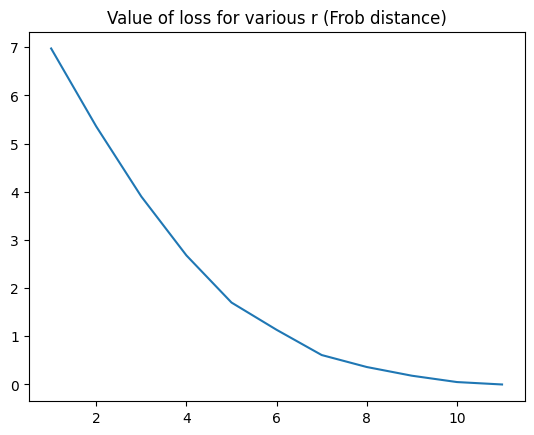

In [55]:
Rdist2 = Recovering(lr=0.02, n_epochs=1000)
loss_dic_dist2 = {}

for r in range(1, 12):
    Rdist2.fit(Z, r, dist_pow=2, verbose=False)
    loss_dic_dist2[r] = Rdist2.loss_list[-1]
    print(f" The loss for r = {r} = {Rdist2.loss_list[-1]}")

plt.plot(loss_dic_dist2.keys(), loss_dic_dist2.values(), label="power = 2 (Frob)")
plt.title("Value of loss for various r (Frob distance)")
plt.show()

* Consider different distance
 $$dist_{4}(\mathbf{Z},\mathbf{W}\mathbf{H})=\sum_{i,j} (\mathbf{Z}[i,j] -(\mathbf{W}\mathbf{H})[i,j])^4$$
 Find "best" matrices $\mathbf{W}, \mathbf{H}$ using SGD/Adam methods. Compare with distance computed for truncated SVD.

 The loss for r = 1 = 91.84764099121094
 The loss for r = 2 = 61.69110870361328
 The loss for r = 3 = 40.41175079345703
 The loss for r = 4 = 22.0336971282959
 The loss for r = 5 = 11.239727973937988
 The loss for r = 6 = 4.905696868896484
 The loss for r = 7 = 1.8864262104034424
 The loss for r = 8 = 1.0574413537979126
 The loss for r = 9 = 1.1756765842437744
 The loss for r = 10 = 0.5638241171836853
 The loss for r = 11 = 0.2923405170440674


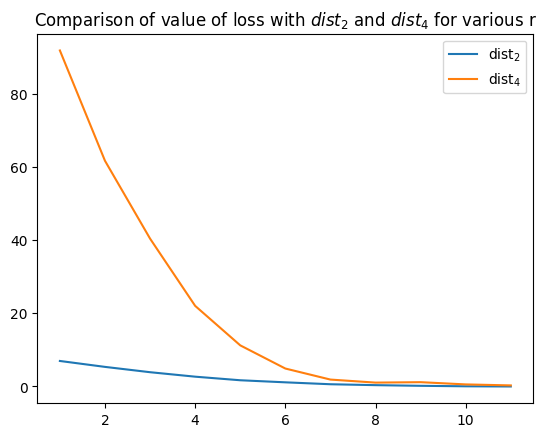

In [56]:
Rdist4 = Recovering(lr=0.02, n_epochs=1000)
loss_dic_dist4 = {}

for r in range(1, 12):
    Rdist4.fit(Z, r, dist_pow=4, verbose=False)
    loss_dic_dist4[r] = Rdist4.loss_list[-1]
    print(f" The loss for r = {r} = {Rdist4.loss_list[-1]}")

plt.plot(loss_dic_dist2.keys(), loss_dic_dist2.values(), label=r'$\text{dist}_2$')
plt.plot(loss_dic_dist4.keys(), loss_dic_dist4.values(), label=r'$\text{dist}_4$')
plt.title(r'Comparison of value of loss with $dist_2$ and $dist_4$ for various r')
plt.legend()
plt.show()

B)
* Approximate the same  $\mathbf{Z}$ as
$$\mathbf{Z}\approx \mathbf{W}\mathbf{H}$$
where $\mathbf{W}$ is of size $n\times r$ and $\mathbf{H}$ is of size $r\times d$ (fix some $r<d$) so that
* a) $\mathbf{W}$ is a symmetric matrix
* b) $\mathbf{W}$ is a symmetric matrix with nonnegative entries
* c) $\mathbf{W}$ is symmetric and each entry of $\mathbf{H}$ is at least 0.5

In [58]:
Rb = Recovering(lr=0.02, n_epochs=1000)
for r in range(1, 8):
    Rb.fit_nonnegativeW(Z, r, dist_pow=2, verbose=False)
    print(f" The loss for r = {r} = {Rb.loss_list[-1]}")

 The loss for r = 1 = 6.973442077636719
 The loss for r = 2 = 5.357255935668945
 The loss for r = 3 = 3.9097483158111572
 The loss for r = 4 = 2.678877592086792
 The loss for r = 5 = 1.7088077068328857
 The loss for r = 6 = 1.1383548974990845
 The loss for r = 7 = 0.6123573780059814
 The loss for r = 8 = 0.36936303973197937


In [68]:
print(f"Z matrix: {Z}")
print(f"Recovered Z matrix: {Rb.get_recovered_Z()}")
print(f"Nonnegative elements of W_r matrix: {Rb.W_r > 0}")

Z matrix: tensor([[9., 5., 4., 8., 5., 2., 2., 1., 7., 4., 2., 2., 4., 1., 7.],
        [5., 8., 2., 5., 0., 6., 7., 6., 6., 7., 7., 9., 1., 1., 3.],
        [5., 1., 8., 1., 4., 3., 0., 2., 8., 3., 8., 0., 1., 1., 0.],
        [5., 5., 7., 2., 6., 2., 5., 0., 6., 9., 3., 9., 3., 1., 6.],
        [2., 6., 1., 9., 7., 8., 0., 6., 4., 3., 8., 8., 3., 6., 8.],
        [5., 3., 1., 0., 5., 6., 9., 8., 2., 7., 9., 6., 5., 8., 3.],
        [6., 6., 3., 3., 7., 5., 0., 7., 2., 6., 3., 7., 0., 8., 6.],
        [2., 3., 0., 6., 0., 3., 9., 4., 2., 8., 4., 2., 4., 5., 2.],
        [1., 1., 8., 3., 3., 6., 9., 8., 8., 5., 3., 0., 2., 2., 4.],
        [3., 1., 5., 0., 6., 5., 1., 8., 9., 0., 2., 3., 3., 7., 7.],
        [4., 5., 3., 0., 6., 2., 1., 0., 3., 8., 9., 0., 3., 8., 8.]])
Recovered Z matrix: tensor([[ 8.9484,  4.9053,  4.1434,  8.2072,  4.8567,  2.4096,  1.7525,  0.7761,
          7.0962,  4.3935,  1.6793,  1.9701,  3.7671,  1.4049,  6.6064],
        [ 4.7910,  6.6776,  2.6905,  5.9588, 

In [66]:
Rc = Recovering(lr=0.02, n_epochs=1000)
for r in range(1, 9):
    Rc.fit_H_greater_than_half(Z, r, dist_pow=2, verbose=False)
    print(f" The loss for r = {r} = {Rc.loss_list[-1]}")

 The loss for r = 1 = 6.973442077636719
 The loss for r = 2 = 5.50858736038208
 The loss for r = 3 = 3.935673475265503
 The loss for r = 4 = 2.6868784427642822
 The loss for r = 5 = 1.709101676940918
 The loss for r = 6 = 1.167107105255127
 The loss for r = 7 = 0.6111830472946167
 The loss for r = 8 = 0.36261799931526184


In [69]:
print(f"Z matrix: {Z}")
print(f"Recovered Z matrix: {Rc.get_recovered_Z()}")
print(f"Elements greater than 0.5 in W_8 matrix: {Rc.H_r > 0.5}")

Z matrix: tensor([[9., 5., 4., 8., 5., 2., 2., 1., 7., 4., 2., 2., 4., 1., 7.],
        [5., 8., 2., 5., 0., 6., 7., 6., 6., 7., 7., 9., 1., 1., 3.],
        [5., 1., 8., 1., 4., 3., 0., 2., 8., 3., 8., 0., 1., 1., 0.],
        [5., 5., 7., 2., 6., 2., 5., 0., 6., 9., 3., 9., 3., 1., 6.],
        [2., 6., 1., 9., 7., 8., 0., 6., 4., 3., 8., 8., 3., 6., 8.],
        [5., 3., 1., 0., 5., 6., 9., 8., 2., 7., 9., 6., 5., 8., 3.],
        [6., 6., 3., 3., 7., 5., 0., 7., 2., 6., 3., 7., 0., 8., 6.],
        [2., 3., 0., 6., 0., 3., 9., 4., 2., 8., 4., 2., 4., 5., 2.],
        [1., 1., 8., 3., 3., 6., 9., 8., 8., 5., 3., 0., 2., 2., 4.],
        [3., 1., 5., 0., 6., 5., 1., 8., 9., 0., 2., 3., 3., 7., 7.],
        [4., 5., 3., 0., 6., 2., 1., 0., 3., 8., 9., 0., 3., 8., 8.]])
Recovered Z matrix: tensor([[ 8.7116,  5.1923,  4.3557,  8.3226,  4.6514,  1.9054,  1.5966,  1.1500,
          7.1109,  4.6327,  1.7193,  1.8327,  3.3889,  1.5313,  6.6788],
        [ 5.0039,  6.6843,  2.6545,  5.9759, 